# Load Libs

In [1]:
# ~~ Original Imports ~~

from os.path import expanduser , join
home = expanduser("~")
# print( home )

import sys
sys.path.append( join( home , 'rm/interfaces/camera_interface'      ) ) 
sys.path.append( join( home , 'rm/interfaces/robot_interface'       ) )
sys.path.append( join( home , 'rm/interfaces/gripper_interface'     ) )
sys.path.append( join( home , 'rm/interfaces/applications'          ) )
sys.path.append( join( home , 'rm/interfaces/applications/WRS_2018' ) )
sys.path.append( join( home , 'rm/interfaces/force_interface'       ) )
sys.path.append( home )

import matplotlib.pyplot as plt
import numpy as np
import xmlrpc.client
import pickle
from math import radians , pi , atan2 , tan , degrees

from time import sleep
import cv2

from HomogXforms import *
from viewer import *
from force_sensor import *
# from ur5 import *
import ur5 ; print( ur5.__file__ )

from gripper import *

from point_cloud_processing import *
from realsense_camera import *

# import gripper
# print( gripper.__file__ )

from pick_tray import *

# ~~ New Imports ~~

from WRS_asm_functions import *

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print( "Libs loaded!" )

/home/nvidia/rm/interfaces/robot_interface/ur5.py
Libs loaded!


# Load Functions

In [74]:
# ~~ File Operations ~~

def unpickle_dict( filename ):
    """ Return the dictionary stored in the file , Otherwise return an empty dictionary if there were no items """
    try:
        infile = open( filename , 'rb' )
        rtnDict = pickle.load( infile )
        if len( rtnDict ) > 0:
            return rtnDict
        else:
            return {}
    except FileNotFoundError:
        return {}
    
def pickle_struct( pStruct , filename ):
    """ Pickle 'pStruct' to 'filename' """
    outfile = open( filename , 'wb' )
    pickle.dump( pStruct , outfile )
    outfile.close()
    print( "Saved:" , filename )
    
def read_file_as_binary( fPath ):
    """ Open the file in binary mode and return its contents """
    # URL , Pickle and Image: https://mail.python.org/pipermail/python-list/2005-April/313870.html
    f = open( fPath , 'rb' )
    f.seek(0)
    rtnData = f.read()
    f.close()
    return rtnData
    
# ~~ Robot Control ~~

def straighten_wrist():
    """ Straighten the wrist pose such that the effector is pointed straight down """
    cur_pose = np.around( get_tcp_pose() , 3 )
    cur_pose[3:] = 3.14, 0.0 , 0.0
    movel( cur_pose )
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print( "Functions loaded!" )

Functions loaded!


# Init

## Start Camera

In [3]:
#start host camera
rsc = RealSenseCamera()
rsc.start_camera()
print( "Host Camera Active:" , rsc.is_running() )

Found device that supports advanced mode: Intel RealSense D410
Found config: <pyrealsense2.config object at 0x7f9e7fce68>
['can_resolve', 'disable_all_streams', 'disable_stream', 'enable_all_streams', 'enable_device', 'enable_device_from_file', 'enable_record_to_file', 'enable_stream', 'resolve']
Host Camera Active: True


## Program Vars

In [4]:
WAYPOINTPATH = "picture_waypoints.pkl"

pose_dict = unpickle_dict( WAYPOINTPATH ) 

# ~~ Hardcoded Points ~~

pose_dict["HOME_JA"] = [ 0 , -pi/2 , 0 , -pi/2 , 0 , 0 ]

# Scan

## Scan Functions

In [5]:
def get_cloud_objects( disp , leaf , searchRad , clusterSize ):
    """ Set the disparity shift, capture point cloud, and separated it into objects """
    global rsc
    rsc.set_disparity_shift( disp )
    cloud = transform_points( rsc.get_point_cloud( post_process_frames = 10)[0] , 
                              get_camera_transform() )
    cloud_vg = voxel_grid( cloud , leaf_size = leaf )
    print( "Filtered cloud has" , len( cloud_vg ) , "points" )
    return get_objects_clouds_dbscan( cloud_vg , search_radius = searchRad , min_cluster_size = clusterSize )

## Scan Object

In [76]:
open_gripper()
dataStore = {}

In [72]:
## ~~ NORTH ~~

set_joint_angles( pose_dict["scan_above_JA"] , speed = 0.5 , acceleration = 0.5 )
set_joint_angles( pose_dict["scan_north_JA"] , speed = 0.5 , acceleration = 0.5 )

1

Filtered cloud has 17138 points
Camera Position: [0.5133074492329566, -0.7028496672531028, -0.7110286061373186]
Camera Bases: [ 0.53429951 -1.39426337  0.16447325] [-0.18954222 -0.4035846   0.8677575 ] [-0.19772116 -0.41506719 -0.5463858 ]
pyntcloud wrote: /home/nvidia/scanviewer_ur5-intellisense/robot_control/pyntcloud_plot.html
pyntcloud_plot init: Camera at [-0.005, 0.005, 0.0] , Looking at: [0.3220533912965728, -0.3878426618302792, -0.06949292174375807]


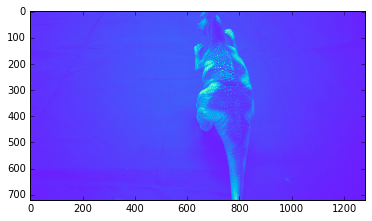

In [78]:
# 1. Fetch point cloud clusters
objs = get_cloud_objects( disp = 145 , leaf = 0.0025 , searchRad = 0.003 , clusterSize = 500 )

# 2. Get the camera transform & bases
cameraXform = get_camera_transform()
cameraPos = pos_from_xform( cameraXform )
print( "Camera Position:" , cameraPos )
cam_xBasis , cam_yBasis , cam_zBasis = get_basis_vectors_for_xform( cameraXform )
print( "Camera Bases:" , cam_xBasis , cam_yBasis , cam_zBasis )

# 3. Get the IR image
ir_image = rsc.get_point_cloud_2()[2]
preview = ir_image.copy()
# plt.imshow( preview , vmin = 0 , vmax = 255 )
plt.imshow( preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )
shotName  = "tallDino_NORTH"
imageName = shotName + ".png"
plt.imsave( imageName , preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )

# 4. Store Data
dataStore[ shotName ] = {
    'cameraPos'   : cameraPos ,
    'cameraXform' : cameraXform.tolist() ,
    'cam_xBasis' :  cam_xBasis , 
    'cam_yBasis' :  cam_yBasis , 
    'cam_zBasis' :  cam_zBasis ,
    'imageName'  :  imageName ,
    'image' :       read_file_as_binary( imageName ) ,
    'cloud_objs' :  objs
}

viewer = Viewer()
# viewer.add_cloud( cloud_vg )
for obj in objs:
    viewer.add_cloud( obj , colorize = True )
viewer.add_axis( cameraXform )
viewer.show()

In [79]:
## ~~ SOUTH ~~

set_joint_angles( pose_dict["scan_above_JA"] , speed = 0.5 , acceleration = 0.5 )
set_joint_angles( pose_dict["scan_south_JA"] , speed = 0.5 , acceleration = 0.5 )

1

Filtered cloud has 14670 points
Camera Position: [0.14979558292916034, -0.17513840962891186, 0.9840015757567168]
Camera Bases: [ 0.11712394 -1.40520997  0.06986073] [-0.02534283 -0.37892108 -0.89265386] [ 1.13379716 -0.43433999 -0.08436972]
pyntcloud wrote: /home/nvidia/scanviewer_ur5-intellisense/robot_control/pyntcloud_plot.html
pyntcloud_plot init: Camera at [-0.005, 0.005, 0.0] , Looking at: [0.4462441999486039, -0.403666276741475, -0.01903150098977539]


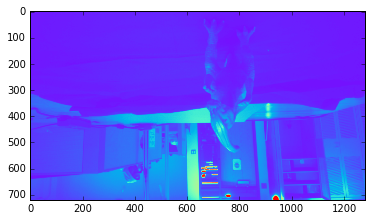

In [81]:
# 1. Fetch point cloud clusters
objs = get_cloud_objects( disp = 140 , leaf = 0.0025 , searchRad = 0.003 , clusterSize = 25 )

# 2. Get the camera transform & bases
cameraXform = get_camera_transform()
cameraPos = pos_from_xform( cameraXform )
print( "Camera Position:" , cameraPos )
cam_xBasis , cam_yBasis , cam_zBasis = get_basis_vectors_for_xform( cameraXform )
print( "Camera Bases:" , cam_xBasis , cam_yBasis , cam_zBasis )

# 3. Get the IR image
ir_image = rsc.get_point_cloud_2()[2]
preview = ir_image.copy()
# plt.imshow( preview , vmin = 0 , vmax = 255 )
plt.imshow( preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )
shotName  = "tallDino_SOUTH"
imageName = shotName + ".png"
plt.imsave( imageName , preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )

# 4. Store Data
dataStore[ shotName ] = {
    'cameraPos'   : cameraPos ,
    'cameraXform' : cameraXform.tolist() ,
    'cam_xBasis' :  cam_xBasis , 
    'cam_yBasis' :  cam_yBasis , 
    'cam_zBasis' :  cam_zBasis ,
    'imageName'  :  imageName ,
    'image' :       read_file_as_binary( imageName ) ,
    'cloud_objs' :  objs
}

viewer = Viewer()
# viewer.add_cloud( cloud_vg )
for obj in objs:
    viewer.add_cloud( obj , colorize = True )
viewer.add_axis( cameraXform )
viewer.show()

In [82]:
## ~~ EAST ~~
set_joint_angles( pose_dict["scan_above_JA"] , speed = 0.5 , acceleration = 0.5 )
set_joint_angles( pose_dict["scan_east_JA"] , speed = 0.5 , acceleration = 0.5 )

1

Filtered cloud has 17274 points
Camera Position: [0.38274733212581447, -0.02678415910667833, 0.06031515121615909]
Camera Bases: [ 1.3805673  -0.54407474  0.16133774] [ 0.35596317 -1.19846766 -0.56112769] [ 0.44306248  0.2129489  -0.57893242]
pyntcloud wrote: /home/nvidia/scanviewer_ur5-intellisense/robot_control/pyntcloud_plot.html
pyntcloud_plot init: Camera at [-0.005, 0.005, 0.0] , Looking at: [0.41086182183284, -0.3089786606991293, -0.0763907781555512]


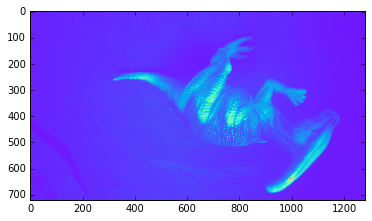

In [83]:
# 1. Fetch point cloud clusters
objs = get_cloud_objects( disp = 155 , leaf = 0.0025 , searchRad = 0.003 , clusterSize = 500 )

# 2. Get the camera transform & bases
cameraXform = get_camera_transform()
cameraPos = pos_from_xform( cameraXform )
print( "Camera Position:" , cameraPos )
cam_xBasis , cam_yBasis , cam_zBasis = get_basis_vectors_for_xform( cameraXform )
print( "Camera Bases:" , cam_xBasis , cam_yBasis , cam_zBasis )

# 3. Get the IR image
ir_image = rsc.get_point_cloud_2()[2]
preview = ir_image.copy()
# plt.imshow( preview , vmin = 0 , vmax = 255 )
plt.imshow( preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )
shotName  = "tallDino_EAST"
imageName = shotName + ".png"
plt.imsave( imageName , preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )

# 4. Store Data
dataStore[ shotName ] = {
    'cameraPos'   : cameraPos ,
    'cameraXform' : cameraXform.tolist() ,
    'cam_xBasis' :  cam_xBasis , 
    'cam_yBasis' :  cam_yBasis , 
    'cam_zBasis' :  cam_zBasis ,
    'imageName'  :  imageName ,
    'image' :       read_file_as_binary( imageName ) ,
    'cloud_objs' :  objs
}

viewer = Viewer()
# viewer.add_cloud( cloud_vg )
for obj in objs:
    viewer.add_cloud( obj , colorize = True )
viewer.add_axis( cameraXform )
viewer.show()

In [84]:
## ~~ WEST ~~

set_joint_angles( pose_dict["scan_above_JA"] , speed = 0.5 , acceleration = 0.5 )
set_joint_angles( pose_dict["scan_west_JA"] , speed = 0.5 , acceleration = 0.5 )

1

Filtered cloud has 14293 points
Camera Position: [0.3983625791746601, -0.0657523270876493, 0.027421039765346513]
Camera Bases: [ 1.39582171 -0.26288928  0.21166026] [ 0.33261025 -0.85092235  0.93539951] [ 0.42578362 -1.03995321 -0.46302319]
pyntcloud wrote: /home/nvidia/scanviewer_ur5-intellisense/robot_control/pyntcloud_plot.html
pyntcloud_plot init: Camera at [-0.005, 0.005, 0.0] , Looking at: [0.4045965470226349, -0.4444149140075799, -0.046420470385739904]


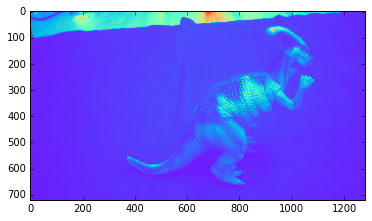

In [86]:
# 1. Fetch point cloud clusters
objs = get_cloud_objects( disp = 155 , leaf = 0.0025 , searchRad = 0.003 , clusterSize = 500 )

# 2. Get the camera transform & bases
cameraXform = get_camera_transform()
cameraPos = pos_from_xform( cameraXform )
print( "Camera Position:" , cameraPos )
cam_xBasis , cam_yBasis , cam_zBasis = get_basis_vectors_for_xform( cameraXform )
print( "Camera Bases:" , cam_xBasis , cam_yBasis , cam_zBasis )

# 3. Get the IR image
ir_image = rsc.get_point_cloud_2()[2]
preview = ir_image.copy()
# plt.imshow( preview , vmin = 0 , vmax = 255 )
plt.imshow( preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )
shotName  = "tallDino_WEST"
imageName = shotName + ".png"
plt.imsave( imageName , preview , vmin = 0 , vmax = 255 , cmap = plt.cm.get_cmap('rainbow') )

# 4. Store Data
dataStore[ shotName ] = {
    'cameraPos'   : cameraPos ,
    'cameraXform' : cameraXform.tolist() ,
    'cam_xBasis' :  cam_xBasis , 
    'cam_yBasis' :  cam_yBasis , 
    'cam_zBasis' :  cam_zBasis ,
    'imageName'  :  imageName ,
    'image' :       read_file_as_binary( imageName ) ,
    'cloud_objs' :  objs
}

viewer = Viewer()
# viewer.add_cloud( cloud_vg )
for obj in objs:
    viewer.add_cloud( obj , colorize = True )
viewer.add_axis( cameraXform )
viewer.show()

## Save Data

In [87]:
print( "About to save a dict with" , len( dataStore ) , "items" )
pickle_struct( dataStore , "tallDno.pkl" )

About to save a dict with 4 items
Saved: tallDno.pkl


# Common Functions

## Camera Functions

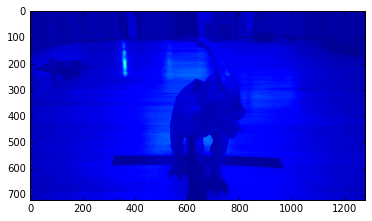

In [21]:
## ~~ IR PREVIEW ~~

ir_image = rsc.get_point_cloud_2()[2]
preview = ir_image.copy()
# image_center = [640,360]
# cv2.line(circleimage,(image_center[0],image_center[1]+100),(image_center[0],image_center[1]-100),
#              (255,255,255),thickness=3)
# cv2.line(circleimage,(image_center[0]+100,image_center[1]), (image_center[0]-100,image_center[1]),
#              (255,255,255),thickness=3)
plt.imshow( preview , vmin = 0 , vmax = 255 )

In [70]:
## ~~ DISPARITY SHIFT ~~
rsc.set_disparity_shift( 140 ) # 140 WEST

In [71]:
## ~~ CLOUD PREVIEW ~~
cloud = transform_points( rsc.get_point_cloud( post_process_frames = 10)[0] , 
                          get_camera_transform() )
cloud_vg = voxel_grid( cloud , leaf_size = 0.0025 )
print( "Filtered cloud has" , len( cloud_vg ) , "points" )

viewer = Viewer()
viewer.add_cloud( cloud_vg )
viewer.show()

Filtered cloud has 16781 points
pyntcloud wrote: /home/nvidia/scanviewer_ur5-intellisense/robot_control/pyntcloud_plot.html
pyntcloud_plot init: Camera at [-0.005, 0.005, 0.0] , Looking at: [0.40961496686446947, -0.47606958541094213, -0.049004860943281915]


In [25]:
## ~~ DISPARITY SHIFT ~~
rsc.set_disparity_shift( 155 ) # 140 WEST

In [34]:
## ~~ OBJECT PREVIEW ~~
cloud = transform_points( rsc.get_point_cloud( post_process_frames = 10)[0] , 
                          get_camera_transform() )
cloud_vg = voxel_grid( cloud , leaf_size = 0.0025 )
print( "Filtered cloud has" , len( cloud_vg ) , "points" )

# cloud_filt = remove_table2( remove_table3( cloud_vg ) , remove_tolerance = 0.0025 )
# cloud_filt = remove_table2( cloud_vg , remove_tolerance = 0.0005 )

ocs = get_objects_clouds_dbscan( cloud_vg , search_radius = 0.003 , min_cluster_size = 500 )
# ocs = get_objects_clouds_dbscan( cloud_filt , search_radius = 0.003 , min_cluster_size = 1000 )

print( "Found" , len( ocs ) , "objects" )

viewer = Viewer()
# viewer.add_cloud( cloud_vg )
for obj in ocs:
    viewer.add_cloud( obj , colorize = True )
viewer.show()

Filtered cloud has 14403 points
Found 3 objects
pyntcloud wrote: /home/nvidia/scanviewer_ur5-intellisense/robot_control/pyntcloud_plot.html
pyntcloud_plot init: Camera at [-0.005, 0.005, 0.0] , Looking at: [0.4143750530661487, -0.44256077087675155, -0.05370460767395059]


## Robot / Gripper Functions

In [35]:
straighten_wrist()

In [6]:
open_gripper()

1

In [34]:
close_gripper()

1

## Camera Functions

In [41]:
rsc.stop_camera()

# Edit Waypoints

In [7]:
from math import degrees
radAngles = get_joint_angles()
print( radAngles )
print( [ degrees( q_i ) for q_i in radAngles ] )

[2.632294178009033, -1.7425912062274378, 2.272782802581787, -2.5448387304889124, -2.1660402456866663, 0.9739853143692017]
[150.81934683677585, -99.84312153344344, 130.22086233785137, -145.80851879844505, -124.1049643333259, 55.80524782107795]


## Scan Waypoints

In [36]:
pose_dict["scan_above_JA"] = get_joint_angles()

In [27]:
pose_dict["scan_west_JA"] = get_joint_angles()

In [18]:
pose_dict["scan_east_JA"] = get_joint_angles()

In [38]:
pose_dict["scan_south_JA"] = get_joint_angles()

In [33]:
pose_dict["scan_north_JA"] = get_joint_angles()

## Save

In [39]:
pickle_struct( pose_dict , WAYPOINTPATH )

Saved: picture_waypoints.pkl
